In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math

In [63]:
new = pd.read_excel('data_2019.xlsx')

In [64]:
cc = new[new['pl_weekday'] =='Poniedziałek']

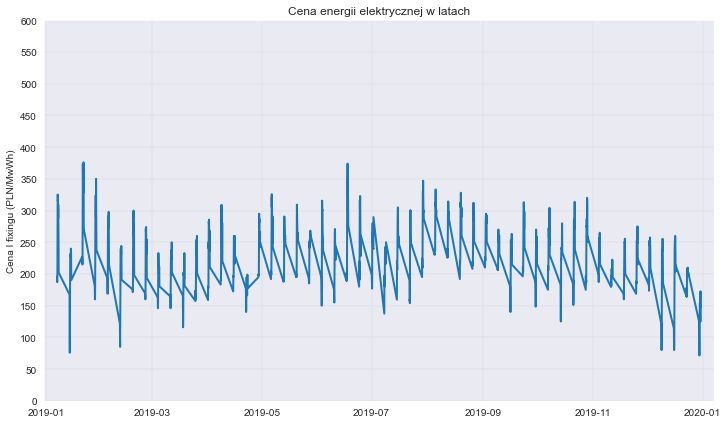

In [66]:
fig = plt.subplots(figsize=(12,7))

plt.plot(cc['date'], cc['fixing I course (PLN/MWh)'], label = 'line 1',
        linewidth=2.0)

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
my_xticks = np.array(cc['date_normalize'])
# frequency = 30
# plt.xticks(my_xticks[::frequency], my_xticks[::frequency], rotation=60)
plt.ylabel("Cena I fixingu (PLN/MwWh)")
plt.margins(0.02)
plt.ylim(120,270, 30)
plt.yticks(np.arange(0, 650, 50))

#plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()

In [67]:
cc

Unnamed: 0                date  fixing I course (PLN/MWh)  month  \
119          119 2019-01-07 00:00:00                     196.01      1   
120          120 2019-01-07 01:00:00                     193.00      1   
121          121 2019-01-07 02:00:00                     190.61      1   
122          122 2019-01-07 03:00:00                     187.10      1   
123          123 2019-01-07 04:00:00                     187.10      1   
...          ...                 ...                        ...    ...   
8705        8705 2019-12-30 19:00:00                     171.63     12   
8706        8706 2019-12-30 20:00:00                     171.74     12   
8707        8707 2019-12-30 21:00:00                     160.71     12   
8708        8708 2019-12-30 22:00:00                     135.98     12   
8709        8709 2019-12-30 23:00:00                     125.29     12   

     month_name  hour  week date_normalize  day_of_week  day_of_month     md  \
119     January     0     2     2019-01-07            0             7  01-07   
120     January     1     2     2019-01-07            0             7  01-07   
121     January     2     2     2019-01-07            0             7  01-07   
122     January     3     2     2019-01-07            0             7  01-07   
123     January     4     2     2019-01-07            0             7  01-07   
...         ...   ...   ...            ...          ...           ...    ...   
8705   December    19     1     2019-12-30            0            30  12-30   
8706   December    20     1     2019-12-30            0            30  12-30   
8707   December    21     1     2019-12-30            0            30  12-30   
8708   December    22     1     2019-12-30            0            30  12-30   
8709   December    23     1     2019-12-30            0            30  12-30   

      season    pl_weekday pl_month_name pl_season_name  quarter  
119   Winter  Poniedziałek       Styczeń           Zima        1  
120   Winter  Poniedziałek       Styczeń           Zima        1  
121   Winter  Poniedziałek       Styczeń           Zima        1  
122   Winter  Poniedziałek       Styczeń           Zima        1  
123   Winter  Poniedziałek       Styczeń           Zima        1  
...      ...           ...           ...            ...      ...  
8705  Winter  Poniedziałek      Grudzień           Zima        4  
8706  Winter  Poniedziałek      Grudzień           Zima        4  
8707  Winter  Poniedziałek      Grudzień           Zima        4  
8708  Winter  Poniedziałek      Grudzień           Zima        4  
8709  Winter  Poniedziałek      Grudzień           Zima        4  

[1248 rows x 16 columns]

In [135]:
cena = cc[['fixing I course (PLN/MWh)']]
scaler = MinMaxScaler(feature_range=(-1, 1))
cena['fixing I course (PLN/MWh)'] = scaler.fit_transform(cena['fixing I course (PLN/MWh)'].values.reshape(-1,1))
cena.reset_index(inplace=False)

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



index  fixing I course (PLN/MWh)
0       119                  -0.182123
1       120                  -0.201892
2       121                  -0.217588
3       122                  -0.240641
4       123                  -0.240641
...     ...                        ...
1243   8705                  -0.342244
1244   8706                  -0.341521
1245   8707                  -0.413963
1246   8708                  -0.576383
1247   8709                  -0.646591

[1248 rows x 2 columns]

In [136]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    
    data = []
    
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.15*data.shape[0]))
    val_set_size = int(np.round(0.15*data.shape[0]))
    
    train_set_size = data.shape[0] - (test_set_size) - (val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[:val_set_size,:-1]
    y_val = data[:val_set_size,-1,:]
    
    x_test = data[:test_set_size,:-1]
    y_test = data[:test_set_size,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [137]:
lookback = 25 # choose sequence length
x_train, y_train, x_val, y_val, x_test, y_test = split_data(cena, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (857, 24, 1)
y_train.shape =  (857, 1)
x_val.shape =  (183, 24, 1)
y_val.shape =  (183, 1)
x_test.shape =  (183, 24, 1)
y_test.shape =  (183, 1)


In [138]:
x_train = torch.from_numpy(x_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))

y_train_lstm = torch.from_numpy(y_train.astype(np.float32))
y_val_lstm = torch.from_numpy(y_val.astype(np.float32))
y_test_lstm = torch.from_numpy(y_test.astype(np.float32))

y_train_gru = torch.from_numpy(y_train.astype(np.float32))
y_val_gru = torch.from_numpy(y_val.astype(np.float32))
y_test_gru = torch.from_numpy(y_test.astype(np.float32))

In [139]:
#Hyper-parametres
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2
num_epochs = 80
sequence_length = 25
learning_rate = 0.05

In [140]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [141]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [142]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.1305948793888092
Epoch  1 MSE:  0.11043716967105865
Epoch  2 MSE:  0.11525746434926987
Epoch  3 MSE:  0.10692546516656876
Epoch  4 MSE:  0.10143530368804932
Epoch  5 MSE:  0.0992995873093605
Epoch  6 MSE:  0.09593092650175095
Epoch  7 MSE:  0.08895546942949295
Epoch  8 MSE:  0.08067920058965683
Epoch  9 MSE:  0.07989703863859177
Epoch  10 MSE:  0.07021476328372955
Epoch  11 MSE:  0.062228284776210785
Epoch  12 MSE:  0.05738873407244682
Epoch  13 MSE:  0.04911243915557861
Epoch  14 MSE:  0.040415409952402115
Epoch  15 MSE:  0.03835369274020195
Epoch  16 MSE:  0.03821960836648941
Epoch  17 MSE:  0.034545496106147766
Epoch  18 MSE:  0.03104119747877121
Epoch  19 MSE:  0.026982994750142097
Epoch  20 MSE:  0.02304377406835556
Epoch  21 MSE:  0.021364212036132812
Epoch  22 MSE:  0.0203668512403965
Epoch  23 MSE:  0.018837329000234604
Epoch  24 MSE:  0.01826501451432705
Epoch  25 MSE:  0.01793942041695118
Epoch  26 MSE:  0.017318159341812134
Epoch  27 MSE:  0.0172411743551492

In [143]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

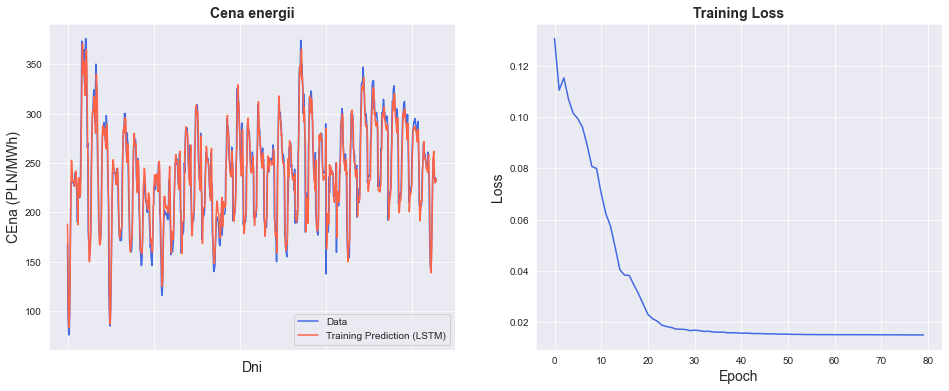

In [144]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Cena energii', size = 14, fontweight='bold')
ax.set_xlabel("Dni", size = 14)
ax.set_ylabel("CEna (PLN/MWh)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [145]:
original.index

RangeIndex(start=0, stop=857, step=1)

In [146]:
original[0]

0      167.400009
1      100.000000
2       86.000000
3       75.839996
4       76.349998
          ...    
852    233.529999
853    235.000000
854    235.000000
855    232.690002
856    231.529999
Name: 0, Length: 857, dtype: float32

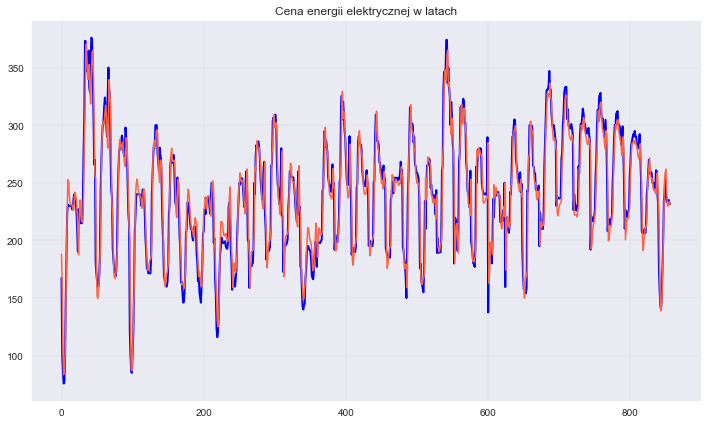

In [147]:
fig = plt.subplots(figsize=(12,7))

plt.plot(original.index, original[0],linewidth=2.0, color='blue', label='Dane')
plt.plot(predict.index, predict[0], label="Training Prediction (LSTM)", color='tomato')

# plt.fill_between(df2019_daily['date_normalize'], df2019_daily['fixing I course (PLN/MWh)'], alpha=0.2)
plt.title('Cena energii elektrycznej w latach',fontsize=12)
#my_xticks = np.array(df['date_normalize'])




#plt.ylabel("Cena I fixingu (PLN/MwWh)")
#plt.margins(0.02)
#plt.ylim(120,270, 30)
#plt.yticks(np.arange(0, 650, 50))

#plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
plt.grid(color='gray', linestyle=':', linewidth=0.35, alpha=0.6, axis='both')
#plt.grid()



plt.show()


In [148]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_val_pred = model(x_val)
y_test_pred = model(x_test)


# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())

y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
y_val = scaler.inverse_transform(y_val_lstm.detach().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_pred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(valScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 18.65 RMSE
Validation Score: 18.23 RMSE
Test Score: 18.23 RMSE


In [149]:
cena

fixing I course (PLN/MWh)
119                   -0.182123
120                   -0.201892
121                   -0.217588
122                   -0.240641
123                   -0.240641
...                         ...
8705                  -0.342244
8706                  -0.341521
8707                  -0.413963
8708                  -0.576383
8709                  -0.646591

[1248 rows x 1 columns]

In [177]:
trainPredictPlot = np.empty_like(cena)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred


In [178]:
valPredictPlot = np.empty_like(cena)
valPredictPlot[:, :] = np.nan
valPredictPlot[lookback:len(y_val_pred)+lookback, :] = y_val_pred


In [179]:
testPredictPlot = np.empty_like(cena)
testPredictPlot[:, :] = np.nan
testPredictPlot[lookback:len(y_test_pred)+lookback, :] = y_test_pred

In [181]:
y_train_pred

array([[187.99022 ],
       [159.1177  ],
       [102.41309 ],
       [ 83.28862 ],
       [ 87.998375],
       [101.1616  ],
       [129.39883 ],
       [186.31036 ],
       [227.17685 ],
       [252.6726  ],
       [250.86046 ],
       [239.30617 ],
       [232.97404 ],
       [230.93872 ],
       [230.33981 ],
       [230.80623 ],
       [227.06833 ],
       [226.2527  ],
       [236.24069 ],
       [241.80518 ],
       [238.5143  ],
       [234.07239 ],
       [223.55348 ],
       [207.80402 ],
       [187.44229 ],
       [223.09436 ],
       [234.99152 ],
       [224.99298 ],
       [216.63527 ],
       [215.83475 ],
       [217.42339 ],
       [237.74089 ],
       [281.93112 ],
       [310.90024 ],
       [364.97083 ],
       [370.71564 ],
       [352.37534 ],
       [339.6082  ],
       [340.04785 ],
       [352.54263 ],
       [328.74435 ],
       [318.31464 ],
       [344.30814 ],
       [363.2107  ],
       [364.58533 ],
       [340.3318  ],
       [301.17783 ],
       [256.3

In [175]:
original = scaler.inverse_transform(cena['fixing I course (PLN/MWh)'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [176]:
trainPredictPlot

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

In [202]:
filepath = 'AMZN_2006-01-01_to_2018-01-01.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
data.head()


Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

In [203]:
price = data[['Close']]

In [204]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [205]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [206]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [207]:
price.shape

(3019, 1)

In [208]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [209]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [210]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [211]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [212]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.8680991530418396
Epoch  1 MSE:  0.5873799324035645
Epoch  2 MSE:  0.3084302544593811
Epoch  3 MSE:  0.04308464378118515
Epoch  4 MSE:  0.38743460178375244
Epoch  5 MSE:  0.167029470205307
Epoch  6 MSE:  0.036791328340768814
Epoch  7 MSE:  0.04813174530863762
Epoch  8 MSE:  0.08488988131284714
Epoch  9 MSE:  0.10524832457304001
Epoch  10 MSE:  0.10696038603782654
Epoch  11 MSE:  0.09611374139785767
Epoch  12 MSE:  0.07921114563941956
Epoch  13 MSE:  0.061604585498571396
Epoch  14 MSE:  0.04714777693152428
Epoch  15 MSE:  0.03807361423969269
Epoch  16 MSE:  0.0349632166326046
Epoch  17 MSE:  0.03685397654771805
Epoch  18 MSE:  0.04159950464963913
Epoch  19 MSE:  0.04657755047082901
Epoch  20 MSE:  0.04964752495288849
Epoch  21 MSE:  0.049878381192684174
Epoch  22 MSE:  0.04761481285095215
Epoch  23 MSE:  0.04398680850863457
Epoch  24 MSE:  0.04026716947555542
Epoch  25 MSE:  0.03740350902080536
Epoch  26 MSE:  0.03583361208438873
Epoch  27 MSE:  0.03552841395139694
Epoch

In [213]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

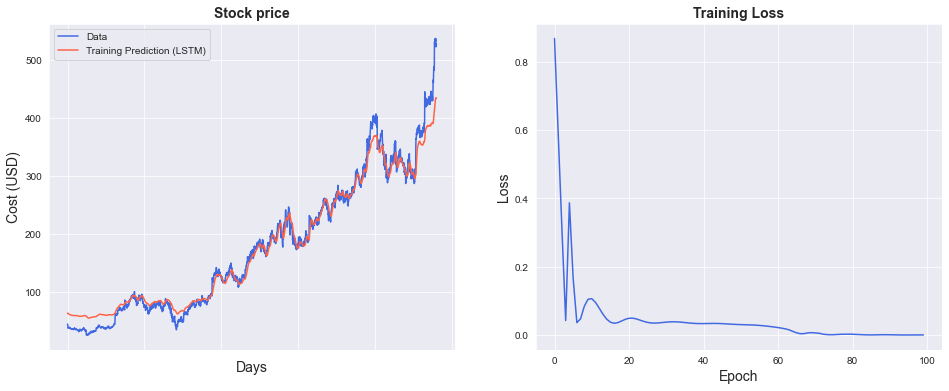

In [214]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [215]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 17.75 RMSE
Test Score: 306.83 RMSE


In [216]:
cena

fixing I course (PLN/MWh)
119                   -0.182123
120                   -0.201892
121                   -0.217588
122                   -0.240641
123                   -0.240641
...                         ...
8705                  -0.342244
8706                  -0.341521
8707                  -0.413963
8708                  -0.576383
8709                  -0.646591

[1248 rows x 1 columns]

In [217]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred



In [ ]:
original = scaler.inverse_transform(cena['fixing I course (PLN/MWh)'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [85]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [86]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    
    data = []
    
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = 24
    val_set_size = 24
    train_set_size = data.shape[0] - (test_set_size) - (val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[:val_set_size,:-1]
    y_val = data[:val_set_size,-1,:]
    
    x_test = data[:train_set_size,:-1]
    y_test = data[:train_set_size,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [16]:
#Hyper-parametres
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2
num_epochs = 80
sequence_length = 25
learning_rate = 0.05

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [18]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(cena_energii_elektrycznej, sequence_length)

In [23]:
x_test.shape

(1175, 24, 1)

Date   Open   High    Low  Close   Volume  Name
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

In [26]:
price = data[['Close']]


In [27]:
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2399, 19, 1)
y_train.shape =  (2399, 1)
x_test.shape =  (600, 19, 1)
y_test.shape =  (600, 1)


In [34]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [36]:
x_train.shape

torch.Size([2399, 19, 1])

In [4]:
electricity_price = pd.read_excel('data_2019.xlsx', usecols=['date', 'fixing I course (PLN/MWh)', 'pl_weekday'])

In [5]:
electricity_price

date  fixing I course (PLN/MWh) pl_weekday
0    2019-01-02 01:00:00                      40.00      Środa
1    2019-01-02 02:00:00                      31.00      Środa
2    2019-01-02 03:00:00                      31.00      Środa
3    2019-01-02 04:00:00                      31.00      Środa
4    2019-01-02 05:00:00                      31.00      Środa
...                  ...                        ...        ...
8729 2019-12-31 19:00:00                     185.00     Wtorek
8730 2019-12-31 20:00:00                     172.28     Wtorek
8731 2019-12-31 21:00:00                     157.63     Wtorek
8732 2019-12-31 22:00:00                     149.99     Wtorek
8733 2019-12-31 23:00:00                     154.71     Wtorek

[8734 rows x 3 columns]

In [ ]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    
    data = []
    
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = 24
    val_set_size = 24
    train_set_size = data.shape[0] - (test_set_size) - (val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[:val_set_size,:-1]
    y_val = data[:val_set_size,-1,:]
    
    x_test = data[:train_set_size,:-1]
    y_test = data[:train_set_size,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [ ]:
#Hyper-parametres
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2
num_epochs = 80
sequence_length = 25
learning_rate = 0.05

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(fixingI_2019, sequence_length)

In [ ]:
x_train = torch.from_numpy(x_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))

y_train_lstm = torch.from_numpy(y_train.astype(np.float32))
y_val_lstm = torch.from_numpy(y_val.astype(np.float32))
y_test_lstm = torch.from_numpy(y_test.astype(np.float32))

y_train_gru = torch.from_numpy(y_train.astype(np.float32))
y_val_gru = torch.from_numpy(y_val.astype(np.float32))
y_test_gru = torch.from_numpy(y_test.astype(np.float32))

## Model: Recurrent Neural Network LSTM and GRU

In [47]:
fixingI_2019 = fixingI_2019_df[['kurs fixingu I (PLN/MWh)']]
scaler = MinMaxScaler(feature_range=(-1, 1))
fixingI_2019['kurs fixingu I (PLN/MWh)'] = scaler.fit_transform(fixingI_2019['kurs fixingu I (PLN/MWh)'].values.reshape(-1,1))

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() 
    
    data = []
    
    
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = 24
    val_set_size = 24
    train_set_size = data.shape[0] - (test_set_size) - (val_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_val = data[:val_set_size,:-1]
    y_val = data[:val_set_size,-1,:]
    
    x_test = data[:train_set_size,:-1]
    y_test = data[:train_set_size,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [49]:
#Hyper-parametres
input_dim = 1
output_dim = 1
hidden_dim = 32
num_layers = 2
num_epochs = 80
sequence_length = 25
learning_rate = 0.05

In [50]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(fixingI_2019, sequence_length)

In [51]:
x_train = torch.from_numpy(x_train.astype(np.float32))
x_val = torch.from_numpy(x_val.astype(np.float32))
x_test = torch.from_numpy(x_test.astype(np.float32))

y_train_lstm = torch.from_numpy(y_train.astype(np.float32))
y_val_lstm = torch.from_numpy(y_val.astype(np.float32))
y_test_lstm = torch.from_numpy(y_test.astype(np.float32))

y_train_gru = torch.from_numpy(y_train.astype(np.float32))
y_val_gru = torch.from_numpy(y_val.astype(np.float32))
y_test_gru = torch.from_numpy(y_test.astype(np.float32))

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)     
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [53]:
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## The training loop

In [54]:
hist = np.zeros(num_epochs)

lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    
    
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()


Epoch  0 MSE:  0.07645082473754883
Epoch  1 MSE:  0.4278249442577362
Epoch  2 MSE:  0.08546724170446396
Epoch  3 MSE:  0.06487542390823364
Epoch  4 MSE:  0.03755948320031166
Epoch  5 MSE:  0.07361715286970139
Epoch  6 MSE:  0.03899180144071579
Epoch  7 MSE:  0.049017854034900665
Epoch  8 MSE:  0.049368876963853836
Epoch  9 MSE:  0.04608051851391792
Epoch  10 MSE:  0.05505327135324478
Epoch  11 MSE:  0.04357339069247246
Epoch  12 MSE:  0.03887737914919853
Epoch  13 MSE:  0.04371728375554085
Epoch  14 MSE:  0.0464271642267704
Epoch  15 MSE:  0.042436279356479645
Epoch  16 MSE:  0.03384045511484146
Epoch  17 MSE:  0.02690449357032776
Epoch  18 MSE:  0.025985127314925194
Epoch  19 MSE:  0.02754914201796055
Epoch  20 MSE:  0.022513961419463158
Epoch  21 MSE:  0.017444729804992676
Epoch  22 MSE:  0.01932167448103428
Epoch  23 MSE:  0.01981324516236782
Epoch  24 MSE:  0.014408409595489502
Epoch  25 MSE:  0.01570238545536995
Epoch  26 MSE:  0.01387625839561224
Epoch  27 MSE:  0.010635546408593

In [55]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

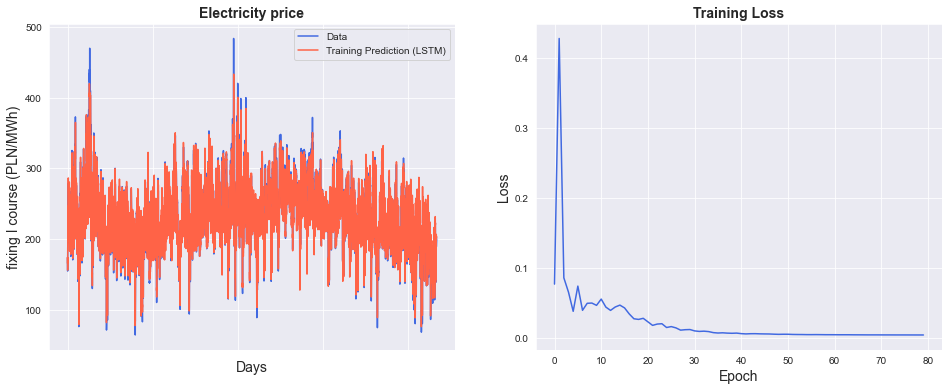

In [56]:
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Electricity price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("fixing I course (PLN/MWh)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [ ]:
y_val_pred = model(x_val)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_val_pred = scaler.inverse_transform(y_val_pred.detach().numpy())
y_val = scaler.inverse_transform(y_val_lstm.detach().numpy())


In [61]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)


Train Score: 13.80 RMSE
Test Score: 11.01 RMSE


In [98]:
y_train

array([[173.56   ],
       [162.38   ],
       [154.51   ],
       ...,
       [202.68   ],
       [199.51   ],
       [189.15999]], dtype=float32)

In [68]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(fixingI_2019)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length:len(y_train_pred)+sequence_length, :] = y_train_preda

In [84]:
# shift test predictions for plotting
valPredictPlot = np.empty_like(fixingI_2019)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(y_train_pred)+sequence_length-1:len(fixingI_2019)-sequence_length, :] = y_val_pred

In [88]:
original = scaler.inverse_transform(fixingI_2019['kurs fixingu I (PLN/MWh)'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, valPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [89]:
result

0   1       2
0    NaN NaN   40.00
1    NaN NaN   31.00
2    NaN NaN   31.00
3    NaN NaN   31.00
4    NaN NaN   31.00
...   ..  ..     ...
8729 NaN NaN  185.00
8730 NaN NaN  172.28
8731 NaN NaN  157.63
8732 NaN NaN  149.99
8733 NaN NaN  154.71

[8734 rows x 3 columns]

In [90]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Val prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (PLN)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [ ]:
plt.savefig('filename.png', dpi=300)

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)     
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.rnn(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = GRU(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
hist = np.zeros(num_epochs)

lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    
    
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(fixingI_2019)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length:len(y_train_pred)+sequence_length, :] = y_train_preda

In [ ]:
# shift test predictions for plotting
valPredictPlot = np.empty_like(fixingI_2019)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(y_train_pred)+sequence_length-1:len(fixingI_2019)-sequence_length, :] = y_val_pred

In [ ]:
original = scaler.inverse_transform(fixingI_2019['kurs fixingu I (PLN/MWh)'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, valPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)


In [4]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

NameError: name 'df' is not defined

In [5]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

NameError: name 'df' is not defined

In [6]:
df = df.dropna(how='any')
df.head()

NameError: name 'df' is not defined

In [7]:

X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

NameError: name 'df' is not defined

In [ ]:

X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [2]:
class Net(nn.Module):

    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 5)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [3]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

NameError: name 'X_train' is not defined